<a href="https://colab.research.google.com/github/areias/viral-escape/blob/main/hiv_viral_escape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

:
# Learning the language of viral evolution and escape - Demo on HIV dataset
1.   paper  https://pubmed.ncbi.nlm.nih.gov/33446556/
2.   supplementary material https://www.science.org/doi/suppl/10.1126/science.abd7331/suppl_file/abd7331-hie-sm.pdf
3.   code https://github.com/brianhie/viral-mutation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Training a new model on HIV Env sequences 

Training on a Tesla P100 with 27.3 GB Ram

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jan 30 19:14:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# clone repository
! git clone https://github.com/brianhie/viral-mutation.git

Cloning into 'viral-mutation'...
remote: Enumerating objects: 1106, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 1106 (delta 131), reused 117 (delta 66), pack-reused 890
Receiving objects: 100% (1106/1106), 177.41 MiB | 34.08 MiB/s, done.
Resolving deltas: 100% (739/739), done.


In [5]:
# download data
!wget http://cb.csail.mit.edu/cb/viral-mutation/data.tar.gz


--2022-01-30 19:14:43--  http://cb.csail.mit.edu/cb/viral-mutation/data.tar.gz
Resolving cb.csail.mit.edu (cb.csail.mit.edu)... 128.30.2.148
Connecting to cb.csail.mit.edu (cb.csail.mit.edu)|128.30.2.148|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3060938794 (2.9G) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]   2.85G  41.0MB/s    in 72s     

2022-01-30 19:15:55 (40.8 MB/s) - ‘data.tar.gz’ saved [3060938794/3060938794]



In [6]:
# unzip data
!tar xvf data.tar.gz

data/
data/escape_results.txt
data/evcouplings/
data/evcouplings/flu_h3_config.yaml
data/evcouplings/flu_h1_config.yaml
data/evcouplings/hiv_bf520_seq.fa
data/evcouplings/hiv_env_seq.fa
data/evcouplings/hiv_env_config.yaml
data/evcouplings/sarscov2_config.yaml
data/evcouplings/flu_h1_seq.fa
data/evcouplings/hiv_bf520_config.yaml
data/evcouplings/sarscov2_seq.fa
data/evcouplings/flu_h3_seq.fa
data/headlines/
data/headlines/abcnews-date-text.csv
data/headlines/headlines.txt
data/hiv/
data/hiv/bg505_regions.txt
data/hiv/fitness_haddox2018/
data/hiv/fitness_haddox2018/BG505-1_prefs.csv
data/hiv/fitness_haddox2018/BG505-3_prefs.csv
data/hiv/fitness_haddox2018/BG505-2_prefs.csv
data/hiv/fitness_haddox2018/BF520-3_prefs.csv
data/hiv/fitness_haddox2018/BF520-2_prefs.csv
data/hiv/fitness_haddox2018/BF520-1_prefs.csv
data/hiv/fitness_haddox2018/BF520_to_HXB2.csv
data/hiv/fitness_haddox2018/BF520_env.fasta
data/hiv/fitness_haddox2018/map_indices.py
data/hiv/fitness_haddox2018/BF520_avgprefs.csv
d

In [7]:
# install dependencies
! pip install anndata 

     |████████████████████████████████| 91 kB 6.0 MB/s 


In [8]:
! pip install scanpy

     |████████████████████████████████| 2.0 MB 7.2 MB/s 
     |████████████████████████████████| 86 kB 8.4 MB/s 
     |████████████████████████████████| 1.1 MB 65.1 MB/s 
     |████████████████████████████████| 63 kB 3.0 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=1bc5af719a7621bf0bbda7a4d2470f550e0a4cac106d44a614a752699cb4499e
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=2b79396673f854104161f46733fe7db6c978d2ce08efe262db6a02a205f26fc5
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=e3644865b0c0810a51617790d9cb2173d18be96580ad47b8cdbd996125c9d037
  Stored in directory: /root/.cache/pip/wheels/68/ca/56/344d532fe53e855ccd6549795d370588ab8123

In [9]:
! pip install bio


     |████████████████████████████████| 271 kB 7.7 MB/s 
     |████████████████████████████████| 2.3 MB 64.7 MB/s 


In [10]:
# python bin/hiv.py bilstm --train --test > hiv_train.log 2>&1

In [5]:
# add mutation to path
import sys
sys.path.append('viral-mutation/bin')

In [6]:
from mutation import *

In [ ]:
np.random.seed(1)
random.seed(1)

In [ ]:
"""def parse_args():
    import argparse
    parser = argparse.ArgumentParser(description='HIV sequence analysis')
    parser.add_argument('model_name', type=str,
                        help='Type of language model (e.g., hmm, lstm)')
    parser.add_argument('--namespace', type=str, default='hiv',
                        help='Model namespace')
    parser.add_argument('--dim', type=int, default=512,
                        help='Embedding dimension')
    parser.add_argument('--batch-size', type=int, default=1000,
                        help='Training minibatch size')
    parser.add_argument('--n-epochs', type=int, default=4,
                        help='Number of training epochs')
    parser.add_argument('--seed', type=int, default=1,
                        help='Random seed')
    parser.add_argument('--checkpoint', type=str, default=None,
                        help='Model checkpoint')
    parser.add_argument('--train', action='store_true',
                        help='Train model')
    parser.add_argument('--train-split', action='store_true',
                        help='Train model on portion of data')
    parser.add_argument('--test', action='store_true',
                        help='Test model')
    parser.add_argument('--embed', action='store_true',
                        help='Analyze embeddings')
    parser.add_argument('--semantics', action='store_true',
                        help='Analyze mutational semantic change')
    parser.add_argument('--combfit', action='store_true',
                        help='Analyze combinatorial fitness')
    args = parser.parse_args()
    return args"""

"def parse_args():\n    import argparse\n    parser = argparse.ArgumentParser(description='HIV sequence analysis')\n    parser.add_argument('model_name', type=str,\n                        help='Type of language model (e.g., hmm, lstm)')\n    parser.add_argument('--namespace', type=str, default='hiv',\n                        help='Model namespace')\n    parser.add_argument('--dim', type=int, default=512,\n                        help='Embedding dimension')\n    parser.add_argument('--batch-size', type=int, default=1000,\n                        help='Training minibatch size')\n    parser.add_argument('--n-epochs', type=int, default=4,\n                        help='Number of training epochs')\n    parser.add_argument('--seed', type=int, default=1,\n                        help='Random seed')\n    parser.add_argument('--checkpoint', type=str, default=None,\n                        help='Model checkpoint')\n    parser.add_argument('--train', action='store_true',\n                       

In [2]:
## creating arguments dict
from collections import namedtuple
arguments = namedtuple('arguments', ['model_name','train','test',
                                     'dim','n_epochs','batch_size',
                                     'namespace', 'seed','checkpoint','train_split'])

args = arguments('bilstm', True, True,
                 512,3,100, # defaults were batch-size 1000, 14 epochs
                 'hiv',1, None,None)
args

arguments(model_name='bilstm', train=True, test=True, dim=512, n_epochs=3, batch_size=100, namespace='hiv', seed=1, checkpoint=None, train_split=None)

In [7]:
AAs = [
    'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H',
    'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W',
    'Y', 'V', 'X', 'Z', 'J', 'U', 'B',
]
vocabulary = { aa: idx + 1 for idx, aa in enumerate(sorted(AAs)) }


In [8]:
from hiv import *

In [ ]:
def setup(args):
    fnames = [ 'data/hiv/HIV-1_env_samelen.fa' ]
    meta_fnames = [ 'data/hiv/HIV-1_env_samelen.fa' ]

    seqs = process(args, fnames, meta_fnames)

    seq_len = max([ len(seq) for seq in seqs ]) + 2
    vocab_size = len(AAs) + 2

    model = get_model(args, seq_len, vocab_size,
                      inference_batch_size=100) # changed from 1000

    return model, seqs


In [ ]:
model, seqs = setup(args)

In [ ]:
len(seqs)

57730

In [ ]:
seqs

{Seq('MRVKEKYQHLWRWGWKWGTMLLGILMICSATEKLWVTVYYGVPVWKEATTTLFC...ILL'): [{'country': 'FR',
   'seqlen': 861,
   'strain': 'IIIB_LAI',
   'subtype': 'B',
   'year': 1983},
  {'country': 'FR',
   'seqlen': 861,
   'strain': 'LAI-J19',
   'subtype': 'B',
   'year': 1983},
  {'country': 'FR',
   'seqlen': 861,
   'strain': 'LAI_BRU',
   'subtype': 'B',
   'year': 1983}],
 Seq('MRVRGTLRNYQQWWIWGVLGFWMLMICNGGGNLWVTVYYGVPVWKEAKTTLLCA...ALQ'): [{'country': 'IN',
   'seqlen': 857,
   'strain': '93IN101',
   'subtype': 'C',
   'year': 1993}],
 Seq('MRVKETQMNWPNLWKWGTLILGLVIICSASENLWVTVYYGVPVWRDADTTLFCA...ALL'): [{'country': 'TH',
   'seqlen': 857,
   'strain': '95TNIH022',
   'subtype': 'AE',
   'year': 1995},
  {'country': 'TH',
   'seqlen': 857,
   'strain': 'ThaiNIH01_C1h',
   'subtype': 'AE',
   'year': 2000}],
 Seq('MRVKETQMSWPNLWKWRTLILGLVIICSASDNLWVTVYYGVPVWRDADTTLFCA...ALL'): [{'country': 'TH',
   'seqlen': 861,
   'strain': '95TNIH047',
   'subtype': 'AE',
   'year': 1995}],
 Seq('MRVMGIQ

In [ ]:
# get sequences subset

In [ ]:
from collections import defaultdict 

seqs_subset= defaultdict(dict)

for x in list(seqs)[0:1000]:
    seqs_subset[x] = seqs[x]


In [ ]:
len(seqs_subset)

1000

In [ ]:
def batch_train(args, model, seqs, vocabulary, batch_size=100,
                verbose=True):
    assert(args.train)

    # Control epochs here.
    n_epochs = args.n_epochs
    #args.n_epochs = 1
    model.n_epochs_ = n_epochs

    n_batches = math.ceil(len(seqs) / float(batch_size))
    if verbose:
        tprint('Traing seq batch size: {}, N batches: {}'
               .format(batch_size, n_batches))

    for epoch in range(n_epochs):
        if verbose:
            tprint('True epoch {}/{}'.format(epoch + 1, n_epochs))
        perm_seqs = [ str(s) for s in seqs.keys() ]
        random.shuffle(perm_seqs)

        for batchi in range(n_batches):
            start = batchi * batch_size
            end = (batchi + 1) * batch_size
            seqs_batch = { seq: seqs[seq] for seq in perm_seqs[start:end] }
            train_test(args, model, seqs_batch, vocabulary)
            del seqs_batch

        fname_prefix = ('drive/MyDrive/target/{0}/checkpoints/{1}/{1}_{2}'
                        .format(args.namespace, args.model_name, args.dim))

        if epoch == 0:
            os.rename('{}-01.hdf5'.format(fname_prefix),
                      '{}-00.hdf5'.format(fname_prefix))
        else:
            os.rename('{}-01.hdf5'.format(fname_prefix),
                      '{}-{:02d}.hdf5'.format(fname_prefix, epoch + 1))
    os.rename('{}-00.hdf5'.format(fname_prefix),
              '{}-01.hdf5'.format(fname_prefix))

In [ ]:
# the default for this was 4 epochs
if args.train:
        batch_train(args, model, seqs_subset, vocabulary, batch_size=100)


2022-01-11 17:28:16.773970 | Traing seq batch size: 100, N batches: 10
2022-01-11 17:28:16.777429 | True epoch 1/3
Epoch 1/3
861/861 [==============================] - 769s 884ms/step - loss: 2.3010 - accuracy: 0.2936
Epoch 2/3
861/861 [==============================] - 767s 891ms/step - loss: 0.8056 - accuracy: 0.7821
Epoch 3/3
861/861 [==============================] - 771s 895ms/step - loss: 0.6178 - accuracy: 0.8194
Epoch 1/3
860/860 [==============================] - 769s 886ms/step - loss: 0.5937 - accuracy: 0.8290
Epoch 2/3
860/860 [==============================] - 760s 884ms/step - loss: 0.5197 - accuracy: 0.8447
Epoch 3/3
860/860 [==============================] - 761s 884ms/step - loss: 0.4663 - accuracy: 0.8568
Epoch 1/3
860/860 [==============================] - 774s 892ms/step - loss: 0.5339 - accuracy: 0.8459
Epoch 2/3
860/860 [==============================] - 766s 891ms/step - loss: 0.4505 - accuracy: 0.8635
Epoch 3/3
860/860 [==============================] - 766s 891

FileNotFoundError: ignored

In [ ]:
if args.train or args.train_split or args.test:
        train_test(args, model, seqs_subset, vocabulary, split_seqs)


Epoch 1/3
1621/1621 [==============================] - 2294s 1s/step - loss: 2.9451 - accuracy: 0.0779
Epoch 2/3
1621/1621 [==============================] - 2291s 1s/step - loss: 1.2038 - accuracy: 0.6537
Epoch 3/3
1621/1621 [==============================] - 2288s 1s/step - loss: 0.1340 - accuracy: 0.9692


## Results

In [ ]:
# saved model in target/flu/checkpoints/bilstm > saved to vsp project locally


In [ ]:
! ls drive/MyDrive/target/flu/checkpoints/bilstm

bilstm_512-01.hdf5  bilstm_512-02.hdf5	bilstm_512-03.hdf5


## Influenza HA semantic embedding UMAPs and statistics 


> ... to understand the semantic patterns learned by our viral language models ... We therefore visualized the semantic
embeddings of each sequence in the influenza, HIV, and coronavirus corpuses using Uniform Manifold Approximation and Projection (UMAP) (13). The resulting two-dimensional semantic landscapes show clustering patterns that correspond to subtype, host species, or both (Fig. 2), suggesting that the model was able to learn functionally meaningful patterns from raw sequence.


Our model trained on only 1,000 sequences for 3 epochs achieves relatively good clustering results as can be visualized by the [graphs](#cell-id) and the following cluster purity statistics:

* Purity, Louvain and subtype: 0.699
* Purity, Louvain and host species: 0.896

For comparison, the full model achieves average cluster purities for HA subtype and HA host species of 99, 96%, respectively.


Of course the embeddings obtained from the full model encode a lot more information when you compare our UMAP graphs with the full model graphs that show a much more disperse landscape.

<insert original graph here>




In [ ]:
! python viral-mutation/bin/flu.py bilstm --checkpoint drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5 --embed > flu_embed.log 2>&1

/bin/bash: line 1:   753 Killed                  python viral-mutation/bin/flu.py bilstm --checkpoint drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5 --embed > flu_embed.log 2>&1


In [17]:
# from bin/flu.py
analyze_embedding(args, model, seqs, vocabulary)


NameError: ignored

In [17]:
from collections import namedtuple
arguments = namedtuple('arguments', ['model_name',
                                     'dim','n_epochs','batch_size',
                                     'namespace','seed','checkpoint'])

args = arguments('bilstm',512,3,100, # defaults were batch-size 1000, 14 epochs
                 'hiv',1, "drive/MyDrive/target/hiv/checkpoints/bilstm/bilstm_512-03.hdf5")
args

arguments(model_name='bilstm', dim=512, n_epochs=3, batch_size=100, namespace='hiv', seed=1, checkpoint='drive/MyDrive/target/hiv/checkpoints/bilstm/bilstm_512-03.hdf5')

In [18]:
# from bin/flu.py
from hiv import *


In [19]:
fnames = [ 'data/hiv/HIV-1_env_samelen.fa' ]
meta_fnames = [ 'data/hiv/HIV-1_env_samelen.fa' ]

seqs = process(args,fnames, meta_fnames)


In [20]:
from collections import defaultdict 

seqs_subset= defaultdict(dict)

for x in list(seqs)[0:1000]:
    seqs_subset[x] = seqs[x]


In [21]:
seq_len = max([ len(seq) for seq in seqs_subset ]) + 2
vocab_size = len(AAs) + 2


In [22]:
#from keras.models import load_model
#model = load_model('drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5')


from language_model import BiLSTMLanguageModel
model = BiLSTMLanguageModel(
    seq_len,
    vocab_size,
    embedding_dim=20,
    hidden_dim=args.dim,
    n_hidden=2,
    n_epochs=args.n_epochs,
    batch_size=args.batch_size,
    inference_batch_size=350,
    seed=args.seed,
    verbose=True,
)



In [23]:
model.model_.load_weights(args.checkpoint)
tprint('Model summary:')
tprint(model.model_.summary())


2022-01-30 19:27:27.112489 | Model summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 900)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 900)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 900, 20)      560         ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  (None, 900, 512)

In [24]:
! pip install igraph

     |████████████████████████████████| 3.1 MB 9.0 MB/s 


In [25]:
! pip install louvain

     |████████████████████████████████| 1.1 MB 9.0 MB/s 


In [26]:
import importlib

In [27]:

importlib.reload(sys.modules['hiv'])
from hiv import *

In [ ]:
!mkdir target/hiv/clusters

<a name="cell-id"></a>
### UMAP graphs 



2022-01-30 19:28:10.649809 | Embedding...
2458/2458 [==============================] - 2090s 850ms/step
2022-01-30 20:03:25.487563 | Done embedding.


viral-mutation/bin/language_model.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  iterate_lengths(lengths, self.seq_len_)
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
... storing 'subtype' as categorical
... storing 'country' as categorical
... storing 'strain' as categorical


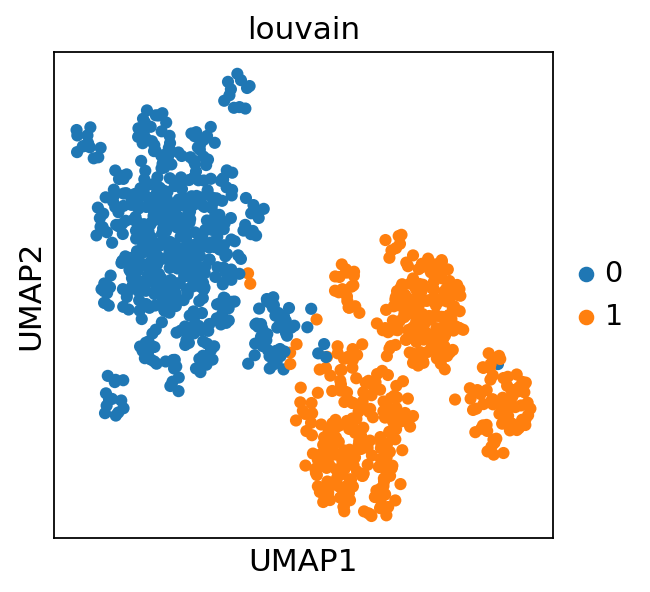

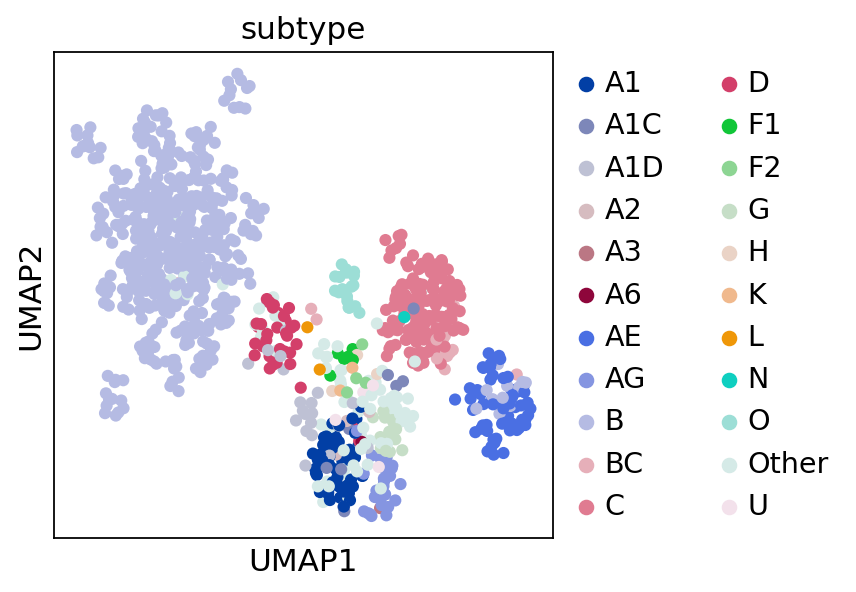

2022-01-30 20:03:47.261753 | Cluster 0
2022-01-30 20:03:47.288290 | 	year:
2022-01-30 20:03:47.290120 | 		2005.0: 70
2022-01-30 20:03:47.293663 | 		1997.0: 67
2022-01-30 20:03:47.295378 | 		1989.0: 44
2022-01-30 20:03:47.298668 | 		1999.0: 30
2022-01-30 20:03:47.299542 | 		1994.0: 24
2022-01-30 20:03:47.301736 | 		1996.0: 20
2022-01-30 20:03:47.303582 | 		1995.0: 19
2022-01-30 20:03:47.304582 | 		2006.0: 18
2022-01-30 20:03:47.305627 | 		1993.0: 18
2022-01-30 20:03:47.308297 | 		1988.0: 16
2022-01-30 20:03:47.310923 | 		1998.0: 11
2022-01-30 20:03:47.312422 | 		1986.0: 11
2022-01-30 20:03:47.313449 | 		1983.0: 10
2022-01-30 20:03:47.314614 | 		2004.0: 9
2022-01-30 20:03:47.315670 | 		1985.0: 8
2022-01-30 20:03:47.316670 | 		2000.0: 7
2022-01-30 20:03:47.317736 | 		1991.0: 6
2022-01-30 20:03:47.318913 | 		1992.0: 5
2022-01-30 20:03:47.319877 | 		1990.0: 4
2022-01-30 20:03:47.321246 | 		1987.0: 4
2022-01-30 20:03:47.322391 | 		2002.0: 3
2022-01-30 20:03:47.325625 | 		2009.0: 3
2022-01-30

In [28]:
# commented out umap 1918 flu since I think there are no observation in my subset
analyze_embedding(args, model, seqs_subset, vocabulary)


## Single-residue escape prediction using validation data from Doud et al. (2018) and Lee et al. (2019) 

> ... we then tested whether combining seman-
tic change and grammaticality enables us to
predict mutations that lead to viral escape.
Our experimental setup involved making, in
silico, all possible single-residue mutations
to a given viral protein sequence; next, each
mutant was ranked according to the CSCS
objective that combines semantic change and
grammaticality. We validated this ranking on
the basis of enrichment of experimentally verified mutants that causally induce escape from
neutralizing antibodies. 

> We computed the area under the curve
(AUC) of acquired escape mutations versus the
total acquired mutations (12). ... escape prediction with CSCS resulted in **both statistically significant and strong AUCs of
0.81, 0.73 for H1 WSN33 and H3 Perth09.**


In comparison, our 1,000 sequences model for H1 WSN33 results in AUC of 
* AUC (CSCS): 0.6943165566179895, P = 0.0
* AUC (semantic change only): 0.5365467547056084
* AUC (grammaticality only): 0.7185742075125345

I still have yet to run the code for H3 Perth09.




The validation data consists of:
* Escape single-residue DMS of HA H1 WSN33 from Doud et al.
(2018); 
* Escape single-residue DMS of HA H3 Perth09 from
Lee et al. (2019)


In [ ]:
# add to to path
import sys
sys.path.append('viral-mutation/bin')

In [ ]:
# load vocabulary
AAs = [
        'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H',
        'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W',
        'Y', 'V', 'X', 'Z', 'J', 'U', 'B', 'Z'
    ]
    
vocabulary = { aa: idx + 1 for idx, aa in enumerate(sorted(AAs)) }



In [ ]:
# load args
from collections import namedtuple
arguments = namedtuple('arguments', ['model_name','namespace','checkpoint',
                                      'dim','n_epochs','batch_size','seed'])

args = arguments('bilstm', 'flu', 'drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5',
                 512,3,350,1)
args

arguments(model_name='bilstm', namespace='flu', checkpoint='drive/MyDrive/target/flu/checkpoints/bilstm/bilstm_512-03.hdf5', dim=512, n_epochs=3, batch_size=350, seed=1)

In [ ]:
# load model
from flu import * 

fnames = [ 'data/influenza/ird_influenzaA_HA_allspecies.fa' ]
meta_fnames = [ 'data/influenza/ird_influenzaA_HA_allspecies_meta.tsv' ]

seqs = process(fnames, meta_fnames)

from collections import defaultdict 

seqs_subset= defaultdict(dict)

for x in list(seqs)[0:1000]:
    seqs_subset[x] = seqs[x]

seq_len = max([ len(seq) for seq in seqs_subset ]) + 2
vocab_size = len(AAs) + 2

from language_model import BiLSTMLanguageModel
model = BiLSTMLanguageModel(
    seq_len,
    vocab_size,
    embedding_dim=20,
    hidden_dim=args.dim,
    n_hidden=2,
    n_epochs=args.n_epochs,
    batch_size=args.batch_size,
    inference_batch_size=350,
    seed=args.seed,
    verbose=True,
)
model.model_.load_weights(args.checkpoint)


In [ ]:
# from flu.py

from escape import load_doud2018, load_lee2019

tprint('Lee et al. 2018...')
seq_to_mutate, escape_seqs = load_doud2018()

"""
analyze_semantics(args, model, vocabulary, seq_to_mutate, escape_seqs,
                    prob_cutoff=0., beta=1., plot_acquisition=True,
                    plot_namespace='flu_h1')
tprint('')

tprint('Lee et al. 2019...')
seq_to_mutate, escape_seqs = load_lee2019()
analyze_semantics(args, model, vocabulary, seq_to_mutate, escape_seqs,
                    prob_cutoff=0., beta=1., plot_acquisition=True,
                    plot_namespace='flu_h3')
"""

2022-01-04 17:44:41.871110 | Lee et al. 2018...


"\nanalyze_semantics(args, model, vocabulary, seq_to_mutate, escape_seqs,\n                    prob_cutoff=0., beta=1., plot_acquisition=True,\n                    plot_namespace='flu_h1')\ntprint('')\n\ntprint('Lee et al. 2019...')\nseq_to_mutate, escape_seqs = load_lee2019()\nanalyze_semantics(args, model, vocabulary, seq_to_mutate, escape_seqs,\n                    prob_cutoff=0., beta=1., plot_acquisition=True,\n                    plot_namespace='flu_h3')\n"

In [ ]:
len(seq_to_mutate)

565

In [ ]:
len(escape_seqs)

10736

In [ ]:
y_pred = predict_sequence_prob(
    args, seq_to_mutate, vocabulary, model, verbose=True)

In [ ]:
y_pred

array([[1.07561533e-08, 1.31496345e-05, 1.57059489e-07, ...,
        9.99410868e-01, 2.38247725e-12, 8.42569392e-09],
       [3.64688990e-09, 3.87536420e-06, 1.95696600e-07, ...,
        3.02035223e-05, 8.40067078e-12, 4.15505630e-09],
       [6.08486152e-06, 9.61071532e-03, 1.47017636e-04, ...,
        1.86240271e-04, 3.31790403e-07, 1.16440306e-05],
       ...,
       [1.49749735e-09, 2.34280506e-09, 4.94858732e-09, ...,
        1.41904240e-11, 6.38366089e-07, 7.48250129e-10],
       [1.90206695e-08, 2.29081056e-08, 1.98895208e-07, ...,
        6.88880966e-11, 8.39728891e-05, 1.31131577e-08],
       [4.49544013e-10, 5.12200171e-10, 2.01064365e-09, ...,
        3.49836566e-12, 9.99730885e-01, 4.19264179e-10]], dtype=float32)

In [ ]:
min_pos=None
max_pos=None

if min_pos is None:
    min_pos = 0
if max_pos is None:
    max_pos = len(seq_to_mutate) - 1


In [ ]:
word_pos_prob = {}
for i in range(min_pos, max_pos + 1):
    for word in vocabulary:
        if seq_to_mutate[i] == word:
            continue
        word_idx = vocabulary[word]
        prob = y_pred[i + 1, word_idx]
        word_pos_prob[(word, i)] = prob


In [ ]:
word_pos_prob

{('A', 0): 3.875364e-06,
 ('B', 0): 1.956966e-07,
 ('C', 0): 3.6517363e-08,
 ('D', 0): 5.911854e-07,
 ('E', 0): 1.7865657e-06,
 ('F', 0): 8.303466e-06,
 ('G', 0): 3.026172e-08,
 ('H', 0): 2.1746813e-09,
 ('I', 0): 0.00011714283,
 ('J', 0): 2.8908774e-08,
 ('K', 0): 2.0078021e-05,
 ('L', 0): 1.3311374e-05,
 ('N', 0): 2.1229867e-05,
 ('P', 0): 2.7974133e-07,
 ('Q', 0): 5.1960278e-08,
 ('R', 0): 3.1007568e-07,
 ('S', 0): 1.2698209e-06,
 ('T', 0): 4.259255e-06,
 ('U', 0): 2.6073836e-09,
 ('V', 0): 1.6788523e-05,
 ('W', 0): 4.272273e-10,
 ('X', 0): 1.8418419e-06,
 ('Y', 0): 7.413977e-06,
 ('Z', 0): 3.0203522e-05,
 ('A', 1): 0.009610715,
 ('B', 1): 0.00014701764,
 ('C', 1): 0.00056215614,
 ('D', 1): 4.8274673e-05,
 ('E', 1): 0.06468596,
 ('F', 1): 0.000504288,
 ('G', 1): 0.00037320412,
 ('H', 1): 2.0290881e-05,
 ('I', 1): 0.024884174,
 ('J', 1): 1.5636513e-05,
 ('L', 1): 0.0029563191,
 ('M', 1): 0.00754108,
 ('N', 1): 0.46458787,
 ('P', 1): 0.00029706865,
 ('Q', 1): 0.00031260384,
 ('R', 1):

In [ ]:
prob_cutoff=0.
prob_seqs = { seq_to_mutate: [ { 'word': None, 'pos': None } ] }
seq_prob = {}
for (word, pos), prob in word_pos_prob.items():
    mutable = seq_to_mutate[:pos] + word + seq_to_mutate[pos + 1:]
    seq_prob[mutable] = prob
    if prob >= prob_cutoff:
        prob_seqs[mutable] = [ { 'word': word, 'pos': pos } ]



In [ ]:
seq_prob

{Seq('AKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 3.875364e-06,
 Seq('BKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 1.956966e-07,
 Seq('CKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 3.6517363e-08,
 Seq('DKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 5.911854e-07,
 Seq('EKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 1.7865657e-06,
 Seq('FKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 8.303466e-06,
 Seq('GKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 3.026172e-08,
 Seq('HKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 2.1746813e-09,
 Seq('IKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 0.00011714283,
 Seq('JKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 2.8908774e-08,
 Seq('KKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 2.0078021e-05,
 Seq('LKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHSVNLLEDSH...ICI'): 

In [ ]:
seqs = np.array([ str(seq) for seq in sorted(seq_prob.keys()) ])


In [ ]:
plot_acquisition=True
plot_namespace=None
if plot_acquisition:
    dirname = ('target/{}/semantics/cache'.format(args.namespace))
    mkdir_p(dirname)
    if plot_namespace is None:
        plot_namespace = args.namespace
            

In [ ]:

if plot_acquisition:
    ofname = dirname + '/{}_mutations.txt'.format(args.namespace)
    with open(ofname, 'w') as of:
        of.write('orig\tmutant\n')
        for seq in seqs:
            try:
                didx = [
                    c1 != c2 for c1, c2 in zip(seq_to_mutate, seq)
                ].index(True)
                of.write('{}\t{}\t{}\n'
                            .format(didx, seq_to_mutate[didx], seq[didx]))
            except ValueError:
                of.write('NA\n')


In [ ]:
base_embedding = embed_seqs(
        args, model, { seq_to_mutate: [ {} ] }, vocabulary,
        use_cache=False, verbose=False)[seq_to_mutate][0]['embedding']

In [ ]:
base_embedding

array([[-4.0877503e-03,  4.7385404e-03,  3.0578572e-01, ...,
         4.9899460e-04,  1.4398832e-04,  2.9687178e-03],
       [-4.7924751e-04,  9.3112671e-01,  2.4223092e-03, ...,
         2.6737031e-05,  3.4821354e-02,  1.7785745e-02],
       [-6.6967487e-02,  2.5158264e-03,  2.0699388e-04, ...,
         8.1472169e-04,  3.6051399e-03,  3.7035710e-01],
       ...,
       [-9.8514205e-01,  1.4412265e-04,  7.4834831e-04, ...,
         7.4405987e-05,  3.4992717e-04,  9.6718976e-03],
       [-8.3217956e-02,  8.7168109e-01,  3.0630312e-05, ...,
         3.3770809e-06,  2.7610385e-04,  1.9304555e-02],
       [-5.2681714e-01,  1.5569000e-05,  5.4204129e-03, ...,
         4.6851624e-06,  2.4655293e-04,  9.4835516e-03]], dtype=float32)

In [ ]:
len(seqs)

13560

In [ ]:
# increasing number of batches
comb_batch=2500
if comb_batch is None:
    comb_batch = len(seqs)
n_batches = math.ceil(float(len(seqs)) / comb_batch)
n_batches

6

In [ ]:
seq_change = {}
for batchi in range(n_batches):
    start = batchi * comb_batch
    end = (batchi + 1) * comb_batch
    prob_seqs_batch = {
        seq: deepcopy(prob_seqs[seq]) for seq in seqs[start:end]
        if seq != seq_to_mutate
    }
    prob_seqs_batch = embed_seqs(
        args, model, prob_seqs_batch, vocabulary,
        use_cache=False, verbose=True
    )
    for mut_seq in prob_seqs_batch:
        meta = prob_seqs_batch[mut_seq][0]
        sem_change = abs(base_embedding - meta['embedding']).sum()
        seq_change[mut_seq] = sem_change
    del prob_seqs_batch

    print(batchi)

2022-01-04 17:45:37.124601 | Embedding...
4050/4050 [==============================] - 2279s 563ms/step
2022-01-04 18:24:22.854917 | Done embedding.
0
2022-01-04 18:24:43.953275 | Embedding...
4050/4050 [==============================] - 2282s 563ms/step
2022-01-04 19:03:21.418442 | Done embedding.
1
2022-01-04 19:03:45.062393 | Embedding...
4050/4050 [==============================] - 2284s 564ms/step
2022-01-04 19:42:38.488916 | Done embedding.
2
2022-01-04 19:43:02.191427 | Embedding...
4050/4050 [==============================] - 2285s 564ms/step
2022-01-04 20:21:38.120591 | Done embedding.
3
2022-01-04 20:22:04.175847 | Embedding...
4050/4050 [==============================] - 2284s 564ms/step
2022-01-04 21:00:43.935656 | Done embedding.
4
2022-01-04 21:01:00.736440 | Embedding...
1718/1718 [==============================] - 967s 563ms/step
2022-01-04 21:17:18.485657 | Done embedding.
5


In [ ]:
cache_fname = dirname + (
    '/analyze_semantics_{}_{}_{}.txt'
    .format(plot_namespace, args.model_name, args.dim)
)

In [ ]:
probs, changes = [], []
with open(cache_fname, 'w') as of:
    fields = [ 'pos', 'wt', 'mut', 'prob', 'change',
                'is_viable', 'is_escape' ]
    of.write('\t'.join(fields) + '\n')
    for seq in seqs:
        prob = seq_prob[seq]
        change = seq_change[seq]
        mut = prob_seqs[seq][0]['word']
        pos = prob_seqs[seq][0]['pos']
        orig = seq_to_mutate[pos]
        is_viable = seq in escape_seqs
        is_escape = ((seq in escape_seqs) and
                        (sum([ m['significant']
                            for m in escape_seqs[seq] ]) > 0))
        fields = [ pos, orig, mut, prob, change, is_viable, is_escape ]
        of.write('\t'.join([ str(field) for field in fields ]) + '\n')
        probs.append(prob)
        changes.append(change)


In [ ]:
beta=1.
if plot_acquisition:
    from cached_semantics import cached_escape



In [ ]:
cache_fname

'target/flu/semantics/cache/analyze_semantics_flu_bilstm_512.txt'

In [ ]:
if plot_acquisition:
    from cached_semantics import cached_escape
    cached_escape(cache_fname, beta,
                plot=plot_acquisition,
                namespace=plot_namespace)

In [ ]:
# from cached_semantics.py
prob_cutoff=0.
beta=1.
plot_acquisition=True,
plot_namespace='flu_h1'
cutoff=None

from escape import load_doud2018
if cutoff is None:
    wt_seq, seqs_escape = load_doud2018()


In [ ]:
prob, change, escape_idx, viable_idx = [], [], [], []
with open(cache_fname) as f:
    f.readline()
    for line in f:
        fields = line.rstrip().split('\t')
        pos = int(fields[0])
        if 'rbd' in cache_fname:
            if pos < 330 or pos > 530:
                continue
        if fields[2] in { 'U', 'B', 'J', 'X', 'Z' }:
            continue
        aa_wt = fields[1]
        aa_mut = fields[2]
        assert(wt_seq[pos] == aa_wt)
        mut_seq = wt_seq[:pos] + aa_mut + wt_seq[pos+1:]
        if mut_seq not in seqs_escape:
            continue
        prob.append(float(fields[3]))
        change.append(float(fields[4]))
        viable_idx.append(fields[5] == 'True')
        escape_idx.append(
            (mut_seq in seqs_escape) and
            (sum([ m['significant']
                    for m in seqs_escape[mut_seq] ]) > 0)
        )

In [ ]:
from sklearn.metrics import auc
from cached_semantics import compute_p

prob, orig_prob = np.array(prob), np.array(prob)
change, orig_change  = np.array(change), np.array(change)
escape_idx = np.array(escape_idx)
viable_idx = np.array(viable_idx)

acquisition = ss.rankdata(change) + (beta * ss.rankdata(prob))

pos_change_idx = change > 0

pos_change_escape_idx = np.logical_and(pos_change_idx, escape_idx)
escape_prob = prob[pos_change_escape_idx]
escape_change = change[pos_change_escape_idx]
prob = prob[pos_change_idx]
change = change[pos_change_idx]

log_prob, log_change = np.log10(prob), np.log10(change)
log_escape_prob, log_escape_change = (np.log10(escape_prob),
                                        np.log10(escape_change))

plot=True
namespace='flu_h1'
if plot:
    mkdir_p('figures')

    plt.figure()
    plt.scatter(log_prob, log_change, c=acquisition[pos_change_idx],
                cmap='viridis', alpha=0.3)
    plt.scatter(log_escape_prob, log_escape_change, c='red',
                alpha=0.5, marker='x')
    plt.xlabel(r'$ \log_{10}(\hat{p}(x_i | \mathbf{x}_{[N] ∖ \{i\} })) $')
    plt.ylabel(r'$ \log_{10}(\Delta \mathbf{\hat{z}}) $')
    plt.savefig('figures/{}_acquisition.png'
                .format(namespace), dpi=300)
    plt.close()

    rand_idx = np.random.choice(len(prob), len(escape_prob))
    plt.figure()
    plt.scatter(log_prob, log_change, c=acquisition[pos_change_idx],
                cmap='viridis', alpha=0.3)
    plt.scatter(log_prob[rand_idx], log_change[rand_idx], c='red',
                alpha=0.5, marker='x')
    plt.xlabel(r'$ \log_{10}(\hat{p}(x_i | \mathbf{x}_{[N] ∖ \{i\} })) $')
    plt.ylabel(r'$ \log_{10}(\Delta \mathbf{\hat{z}}) $')
    plt.savefig('figures/{}_acquisition_rand.png'
                .format(namespace), dpi=300)
    plt.close()

if len(escape_prob) == 0:
    print('No escape mutations found.')
    #return

acq_argsort = ss.rankdata(-acquisition)
escape_rank_dist = acq_argsort[escape_idx]

size = len(prob)
print('Number of escape seqs: {} / {}'
        .format(len(escape_rank_dist), sum(escape_idx)))
print('Mean rank: {} / {}'.format(np.mean(escape_rank_dist), size))
print('Median rank: {} / {}'.format(np.median(escape_rank_dist), size))
print('Min rank: {} / {}'.format(np.min(escape_rank_dist), size))
print('Max rank: {} / {}'.format(np.max(escape_rank_dist), size))
print('Rank stdev: {} / {}'.format(np.std(escape_rank_dist), size))

max_consider = len(prob)
n_consider = np.array([ i + 1 for i in range(max_consider) ])

n_escape = np.array([ sum(escape_rank_dist <= i + 1)
                        for i in range(max_consider) ])
norm = max(n_consider) * max(n_escape)
norm_auc = auc(n_consider, n_escape) / norm

escape_rank_prob = ss.rankdata(-orig_prob)[escape_idx]
n_escape_prob = np.array([ sum(escape_rank_prob <= i + 1)
                            for i in range(max_consider) ])
norm_auc_prob = auc(n_consider, n_escape_prob) / norm

escape_rank_change = ss.rankdata(-orig_change)[escape_idx]
n_escape_change = np.array([ sum(escape_rank_change <= i + 1)
                                for i in range(max_consider) ])
norm_auc_change = auc(n_consider, n_escape_change) / norm

if plot:
    plt.figure()
    plt.plot(n_consider, n_escape)
    plt.plot(n_consider, n_escape_change, c='C0', linestyle='-.')
    plt.plot(n_consider, n_escape_prob, c='C0', linestyle=':')
    plt.plot(n_consider, n_consider * (len(escape_prob) / len(prob)),
                c='gray', linestyle='--')

    plt.xlabel(r'$ \log_{10}() $')
    plt.ylabel(r'$ \log_{10}(\Delta \mathbf{\hat{z}}) $')

    plt.legend([
        r'$ \Delta \mathbf{\hat{z}} + ' +
        r'\beta \hat{p}(x_i | \mathbf{x}_{[N] ∖ \{i\} }) $,' +
        (' AUC = {:.3f}'.format(norm_auc)),
        r'$  \Delta \mathbf{\hat{z}} $ only,' +
        (' AUC = {:.3f}'.format(norm_auc_change)),
        r'$ \hat{p}(x_i | \mathbf{x}_{[N] ∖ \{i\} }) $ only,' +
        (' AUC = {:.3f}'.format(norm_auc_prob)),
        'Random guessing, AUC = 0.500'
    ])
    plt.xlabel('Top N')
    plt.ylabel('Number of escape mutations in top N')
    plt.savefig('figures/{}_consider_escape.png'
                .format(namespace), dpi=300)
    plt.close()


print('Escape semantics, beta = {} [{}]'
        .format(beta, namespace))

norm_auc_p = compute_p(norm_auc, sum(escape_idx), len(escape_idx))

print('AUC (CSCS): {}, P = {}'.format(norm_auc, norm_auc_p))
print('AUC (semantic change only): {}'.format(norm_auc_change))
print('AUC (grammaticality only): {}'.format(norm_auc_prob))

print('{:.4g} (mean log prob), {:.4g} (mean log prob escape), '
        '{:.4g} (p-value)'
        .format(log_prob.mean(), log_escape_prob.mean(),
                ss.mannwhitneyu(log_prob, log_escape_prob,
                                alternative='two-sided')[1]))
print('{:.4g} (mean log change), {:.4g} (mean log change escape), '
        '{:.4g} (p-value)'
        .format(change.mean(), escape_change.mean(),
                ss.mannwhitneyu(change, escape_change,
                                alternative='two-sided')[1]))


Number of escape seqs: 170 / 170
Mean rank: 3281.8382352941176 / 10735
Median rank: 2551.75 / 10735
Min rank: 9.0 / 10735
Max rank: 10421.0 / 10735
Rank stdev: 2796.440226958164 / 10735
Escape semantics, beta = 1.0 [flu_h1]
AUC (CSCS): 0.6943165566179895, P = 0.0
AUC (semantic change only): 0.5365467547056084
AUC (grammaticality only): 0.7185742075125345
-4.292 (mean log prob), -3.139 (mean log prob escape), 1.189e-22 (p-value)
2026 (mean log change), 2228 (mean log change escape), 0.1015 (p-value)


### Flu escape prediction graph

* X-axis is Grammaticality
* Y-axis is Semantic change 

Red x's represent escape mutants, they are mostly localted in the high semantic change and high grammaticallity quadrant (upper right)

![](https://raw.githubusercontent.com/areias/viral-escape/main/figures/flu_h1_acquisition.png) 


The figure below shows our model is learning the grammaticallity of a sequence (the output probability of the model) better than it is the semantic representation.

> Internally, the language model constructs a semantic representa-
tion, or an “embedding,” for a given sequence
(6), and the output of a language model en-
codes how well a particular token fits within
the rules of the language, which we call “gram-
maticality”



![](https://raw.githubusercontent.com/areias/viral-escape/main/figures/flu_h1_consider_escape.png) 